# Backpropagation and the MLP
From: https://rolisz.ro/2013/04/18/neural-networks-in-python/

## Loading the packages

In [1]:
import numpy as np

## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {1,-1}.

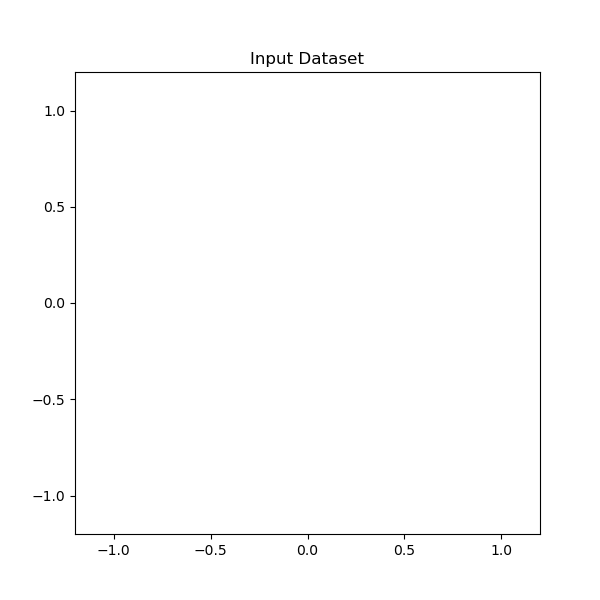

In [2]:
%matplotlib widget
import matplotlib.pyplot as pl

fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-1.2,1.2))
pl.ylim((-1.2,1.2))

dataset = []

def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button
    dataset.append((cx, cy, co-2))

    pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
    pl.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Show the dataset

In [3]:
dataset = np.array(dataset)
dataset

array([[ 0.66322581,  0.11761364, -1.        ],
       [ 0.79225806,  0.07605519, -1.        ],
       [ 0.85419355, -0.31355519, -1.        ],
       [ 0.56516129, -0.52654221, -1.        ],
       [ 0.49290323, -0.17329545, -1.        ],
       [ 0.63741935, -0.07459416, -1.        ],
       [ 0.84387097, -0.14212662, -1.        ],
       [ 1.00903226, -0.14212662, -1.        ],
       [ 1.10709677, -0.53173701, -1.        ],
       [ 1.07096774, -0.72913961, -1.        ],
       [ 0.94193548, -0.82784091, -1.        ],
       [ 0.83870968, -1.0148539 , -1.        ],
       [ 0.53935484, -1.07199675, -1.        ],
       [ 0.32258065, -0.99407468, -1.        ],
       [ 0.12129032, -0.95771104, -1.        ],
       [-0.16258065, -0.97849026, -1.        ],
       [-0.42580645, -0.98368506, -1.        ],
       [-0.57032258, -0.96810065, -1.        ],
       [-0.72516129, -0.93173701, -1.        ],
       [-0.74580645, -0.80186688, -1.        ],
       [-0.70967742, -0.68758117, -1.   

## The MLP
The class presented here was adapted from the code found at: https://rolisz.ro/2013/04/18/neural-networks-in-python/

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

In [4]:
class MLP:
    '''
    This code was adapted from:
    https://rolisz.ro/2013/04/18/neural-networks-in-python/
    '''
    def __tanh(self, x):
        '''Hyperbolic tangent function'''
        return np.tanh(x)

    def __tanh_deriv(self, a):
        '''Hyperbolic tangent derivative'''
        return 1.0 - a**2

    def __logistic(self, x):
        '''Sigmoidal function'''
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_derivative(self, a):
        '''sigmoidal derivative'''
        return a * ( 1 - a )
    
    def __init__(self, layers, activation='tanh'):
        '''
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        '''
        self.n_inputs = layers[0]                               # Number of inputs (first layer)
        self.n_outputs = layers[-1]                             # Number of ouputs (last layer)
        self.layers = layers
                                                                # Activation function
        if activation == 'logistic':
            self.activation = self.__logistic
            self.activation_deriv = self.__logistic_derivative
        elif activation == 'tanh':
            self.activation = self.__tanh
            self.activation_deriv = self.__tanh_deriv

        self.init_weights()                                     # Initialize the weights of the MLP
        
    def init_weights(self):
        '''
        This function creates the matrix of weights and initialiazes their values to small values
        '''
        self.weights = []                                       # Start with an empty list
        for i in range(1, len(self.layers) - 1):                # Iterates through the layers
                                                                # np.random.random((M, N)) returns a MxN matrix
                                                                # of random floats in [0.0, 1.0).
                                                                # (self.layers[i] + 1) is number of neurons in layer i plus the bias unit
            self.weights.append((2 * np.random.random((self.layers[i - 1] + 1, self.layers[i])) - 1) * 0.25)
                                                                # delta_weights are initialized to zero
                                                                # Append a last set of weigths connecting the output of the network
        self.weights.append((2 * np.random.random((self.layers[i] + 1, self.layers[i + 1])) - 1) * 0.25)
   
    def fit(self, data_train, data_test=None, learning_rate=0.1, epochs=100):
        '''
        Online learning.
        :param data_train: A tuple (X, y) with input data and targets for training
        :param data_test: A tuple (X, y) with input data and targets for testing
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        '''
        X = np.atleast_2d(data_train[0])                        # Inputs for training
        #temp = np.ones([X.shape[0], X.shape[1]+1])              # Append the bias unit to the input layer
        #temp[:, 0:-1] = X                                       
        #X = temp                                                # X contains now the inputs plus a last column of ones (bias unit)
        y = np.array(data_train[1])                             # Targets for training
        error_train = np.zeros(epochs)                          # Initialize the array to store the error during training (epochs)
        if data_test is not None:                               # If the test data is provided
            error_test = np.zeros(epochs)                       # Initialize the array to store the error during testing (epochs)
            out_test = np.zeros(data_test[1].shape)             # Initialize the array to store the output during testing
            
        a = []                                                  # Create a list of arrays of activations
        for l in self.layers:
            a.append(np.zeros(l))                               # One array of zeros per layer
            
        for k in range(epochs):                                 # Iterate through the epochs
            error_it = np.zeros(X.shape[0])                     # Initialize an array to store the errors during training (n examples)
            for it in range(X.shape[0]):                        # Iterate through the examples in the training set
                i = np.random.randint(X.shape[0])               # Select one random example
                a[0] = X[i]                                     # The activation of the first layer is the input values of the example

                                                                # Feed-forward
                for l in range(len(self.weights)):              # Iterate and compute the activation of each layer
                    a[l] = np.concatenate((a[l], np.ones(1)))   # Append one for the bias
                    a[l+1] = self.activation(np.dot(a[l], self.weights[l])) # Apply the activation function to the product input.weights
                
                error = a[-1] - y[i]                            # Compute the error: output - target
                error_it[it] = np.mean(error ** 2)              # Store the error of this iteration (average of all the outputs)
                deltas = [error * self.activation_deriv(a[-1])] # Ponderate the error by the derivative = delta
                
                                                                # Back-propagation
                                                                # We need to begin at the layer previous to the last one (out->in)
                for l in range(len(a) - 2, 0, -1):              # Append a delta for each layer
                    deltas.append(deltas[-1].dot(self.weights[l].T) * self.activation_deriv(a[l]))
                    deltas[-1] = deltas[-1][:-1]                # delete the delta of the bias since bias units are not connected backwards
                deltas.reverse()                                # Reverse the list (in->out)

                                                                # Update
                for i in range(len(self.weights)):              # Iterate through the layers
                    layer = np.atleast_2d(a[i])                 # Activation
                    delta = np.atleast_2d(deltas[i])            # Delta
                                                                # Compute the weight change using the delta for this layer
                                                                # and the change computed for the previous example for this layer
                    delta_weights = -learning_rate * layer.T.dot(delta)
                    self.weights[i] += delta_weights            # Update the weights
                
            error_train[k] = np.mean(error_it)                  # Compute the average of the error of all the examples
            if data_test is not None:                           # If a testing dataset was provided
                error_test[k], _ = self.compute_MSE(data_test)  # Compute the testing error after iteration k
            
        if data_test is None:                                   # If only a training data was provided
            return error_train                                  # Return the error during training
        else:
            return (error_train, error_test)                    # Otherwise, return both training and testing error
        
    def predict(self, x):
        '''
        Evaluates the network for a single observation
        '''
        a = np.array(x)
        for l in range(0, len(self.weights)):
            temp = np.ones(a.shape[0]+1)          # append the activation of the bias unit (1)
            temp[0:-1] = a
            a = self.activation(np.dot(temp, self.weights[l]))
        return a
    
    def compute_output(self, data):
        '''
        Evaluates the network for a dataset with multiple observations
        '''
        assert len(data.shape) == 2, 'data must be a 2-dimensional array'

        out = np.zeros((data.shape[0], self.n_outputs))
        for r in np.arange(data.shape[0]):
            out[r,:] = self.predict(data[r,:])
        return out
    
    def compute_MSE(self, data_test):
        '''
        Evaluates the network for a given dataset and
        computes the error between the target data provided
        and the output of the network
        '''
        assert len(data_test[0].shape) == 2, 'data[0] must be a 2-dimensional array'

        out = self.compute_output(data_test[0])
        return (np.mean((data_test[1] - out) ** 2), out)

In [5]:
class MLP:
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_derivative(self, a):
        return a * (1 - a)

    def __init__(self, layers, activation='tanh'):
        self.n_inputs = layers[0]
        self.n_outputs = layers[-1]
        self.layers = layers

        if activation == 'logistic':
            self.activation = self.__logistic
            self.activation_deriv = self.__logistic_derivative
        elif activation == 'tanh':
            self.activation = self.__tanh
            self.activation_deriv = self.__tanh_deriv

        self.init_weights()

    def init_weights(self):
        self.weights = []
        for i in range(1, len(self.layers) - 1):
            self.weights.append((2 * np.random.random((self.layers[i - 1] + 1, self.layers[i])) - 1) * 0.25)
        self.weights.append((2 * np.random.random((self.layers[i] + 1, self.layers[i + 1])) - 1) * 0.25)

    def fit(self, data_train, data_test=None, learning_rate=0.1, momentum=0.5, epochs=100):
        X = np.atleast_2d(data_train[0])
        y = np.array(data_train[1])
        error_train = np.zeros(epochs)

        if data_test is not None:
            error_test = np.zeros(epochs)

        a = []
        for l in self.layers:
            a.append(np.zeros(l))

        for k in range(epochs):
            error_it = np.zeros(X.shape[0])
            prev_delta_weights = [np.zeros_like(w) for w in self.weights]

            for it in range(X.shape[0]):
                i = np.random.randint(X.shape[0])
                a[0] = X[i]

                for l in range(len(self.weights)):
                    a[l] = np.concatenate((a[l], np.ones(1)))
                    a[l+1] = self.activation(np.dot(a[l], self.weights[l]))

                error = a[-1] - y[i]
                error_it[it] = np.mean(error ** 2)
                deltas = [error * self.activation_deriv(a[-1])]

                for l in range(len(a) - 2, 0, -1):
                    deltas.append(deltas[-1].dot(self.weights[l].T) * self.activation_deriv(a[l]))
                    deltas[-1] = deltas[-1][:-1]

                deltas.reverse()

                for i in range(len(self.weights)):
                    layer = np.atleast_2d(a[i])
                    delta = np.atleast_2d(deltas[i])

                    delta_weights = -learning_rate * layer.T.dot(delta) + momentum * prev_delta_weights[i]
                    self.weights[i] += delta_weights

                    prev_delta_weights[i] = delta_weights

            error_train[k] = np.mean(error_it)

            if data_test is not None:
                error_test[k], _ = self.compute_MSE(data_test)

        if data_test is None:
            return error_train
        else:
            return error_train, error_test

    def predict(self, x):
        a = np.array(x)
        for l in range(0, len(self.weights)):
            temp = np.ones(a.shape[0]+1)
            temp[0:-1] = a
            a = self.activation(np.dot(temp, self.weights[l]))
        return a

    def compute_output(self, data):
        assert len(data.shape) == 2, 'data must be a 2-dimensional array'

        out = np.zeros((data.shape[0], self.n_outputs))
        for r in np.arange(data.shape[0]):
            out[r, :] = self.predict(data[r, :])
        return out

    def compute_MSE(self, data_test):
        assert len(data_test[0].shape) == 2, 'data[0] must be a 2-dimensional array'

        out = self.compute_output(data_test[0])
        return np.mean((data_test[1] - out) ** 2), out

In [6]:
%matplotlib inline

## Learning
Let use the MLP class to solve a classification problem

### Create the MLP

In [7]:
input_data = dataset[:,0:2]
output_data = dataset[:,2]
nn = MLP([2,2,1], 'tanh')
# 2 inputs
# 2 hidden nodes
# 1 output

### Use backpropagation to find the network parameters

In [8]:
MSE = nn.fit((input_data, output_data), learning_rate=0.001, epochs=500)

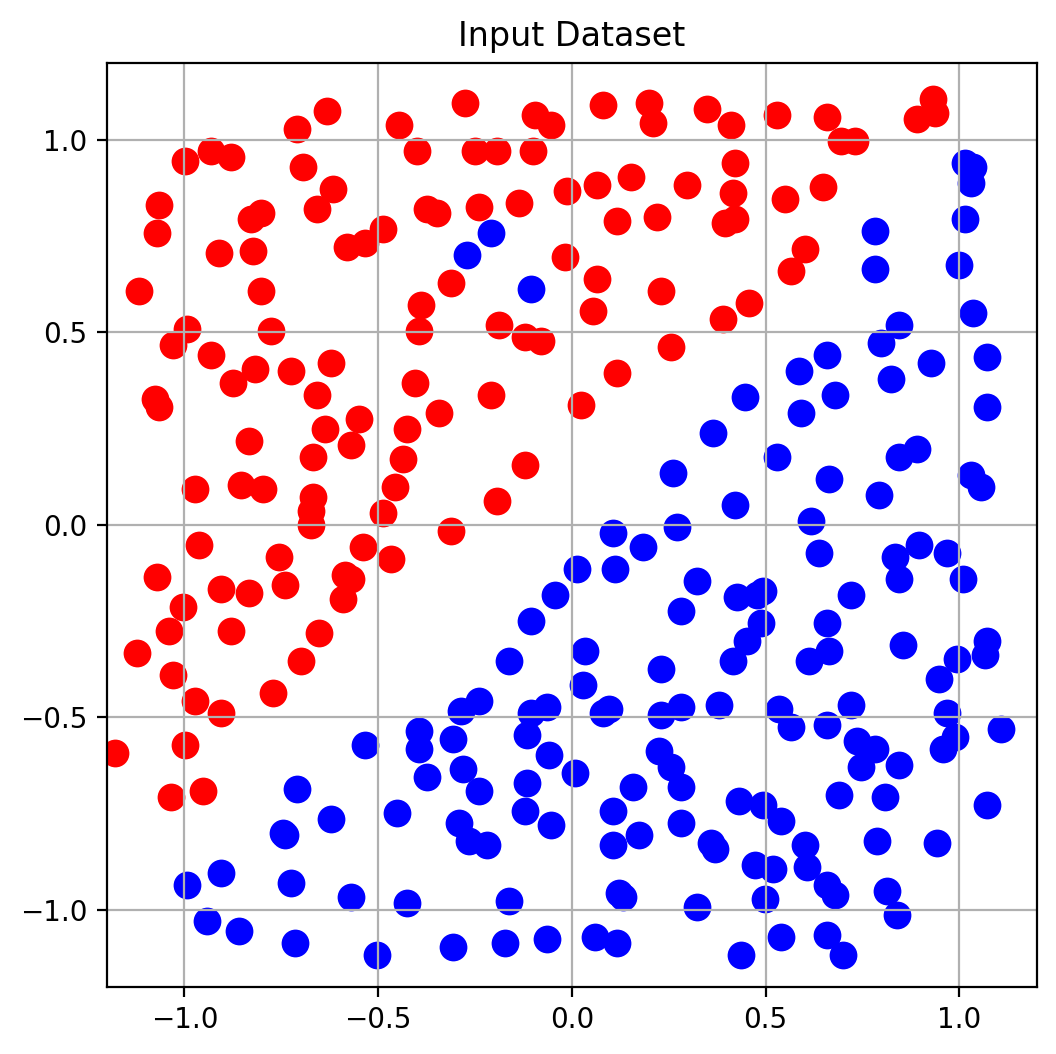

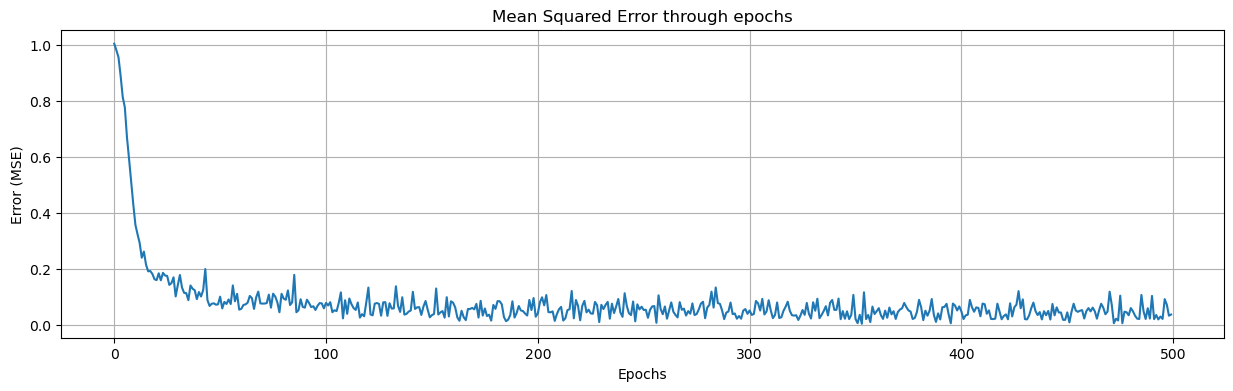

In [9]:
# plot the error through the iterations of the algorithm
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.ylabel('Error (MSE)')
pl.xlabel('Epochs')
pl.title('Mean Squared Error through epochs')
pl.grid()

## Testing
Now, let's use the trained network to predict the classes in the dataset.
This section shows three different manners of showing the outputs of the network, and how to compare its output with the targets to evaluate the performance of the classification.

### Compute the output of the network

In [10]:
output = nn.compute_output(input_data)

### Plot boxplots of the output

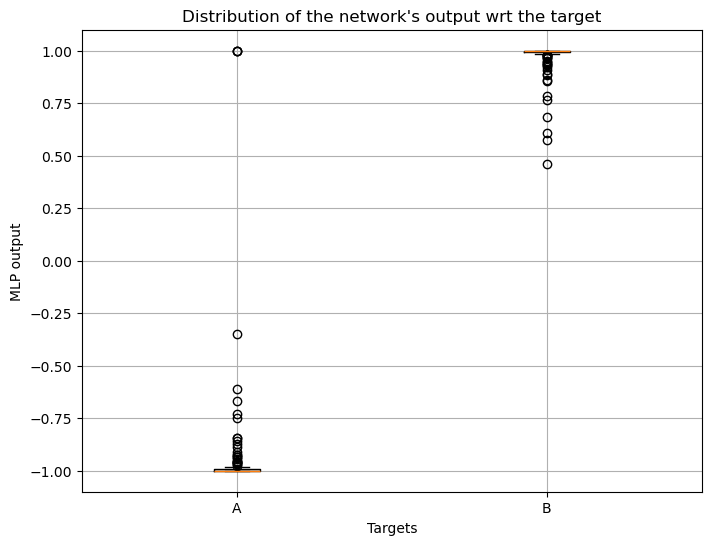

In [11]:
pl.figure(figsize=(8,6))
pl.boxplot(output[output_data==-1.0], positions=[1], labels=['A'])
pl.boxplot(output[output_data==1.0], positions=[2], labels=['B'])
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.title("Distribution of the network's output wrt the target")
pl.grid()

### Plot the output of the network in the space of features (2D)

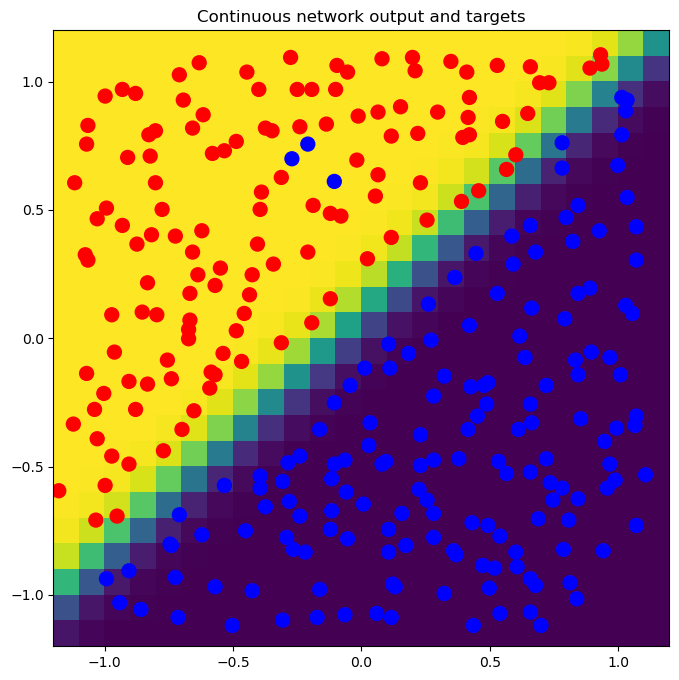

In [12]:
input_x = np.arange(-1.2, 1.2, 0.1)
input_y = np.arange(-1.2, 1.2, 0.1)
input_x_matrix, input_y_matrix = np.meshgrid(input_x, input_y)
inputs_xy = np.concatenate((input_x_matrix.flatten()[:,np.newaxis], input_y_matrix.flatten()[:,np.newaxis]), axis=1)

output_values = nn.compute_output(inputs_xy)
output_matrix = np.reshape(output_values, input_x_matrix.shape)

pl.figure(figsize=(8,8))
pl.imshow(np.flipud(output_matrix), interpolation='None', extent=(-1.2,1.2,-1.2,1.2))
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[int(d>0)] for d in output_data], s=100)
pl.title('Continuous network output and targets');

### Plot targets and predicted outputs separately

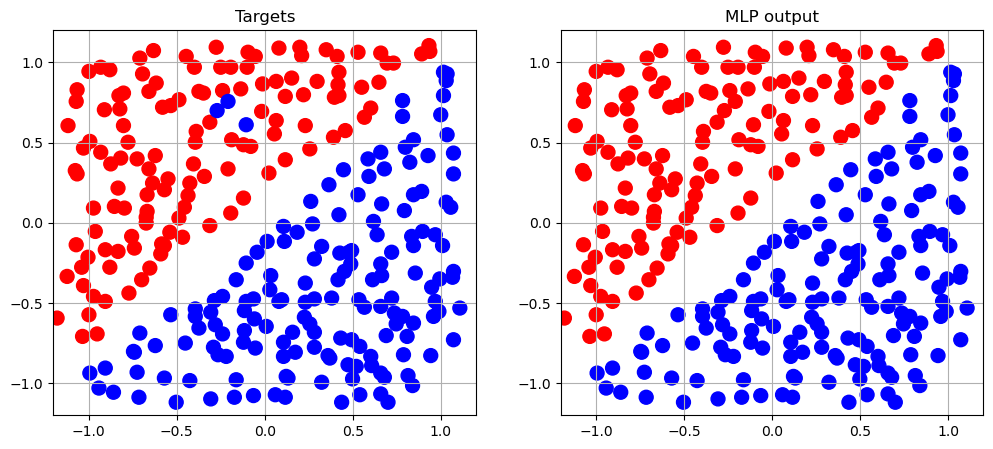

In [13]:
pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[int(d>0)] for d in output_data], s=100)
pl.xlim(-1.2, 1.2)
pl.ylim(-1.2, 1.2)
pl.grid()
pl.title('Targets')
pl.subplot(1,2,2)
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[int(d>0)] for d in output[:,0]], s=100)
pl.xlim(-1.2, 1.2)
pl.ylim(-1.2, 1.2)
pl.grid()
pl.title('MLP output');

The MLP method is saved in a file named `mlp_backprop_momentum.py`. This file will be used later.